In [2]:
import numpy as np
import matplotlib.pyplot as plt

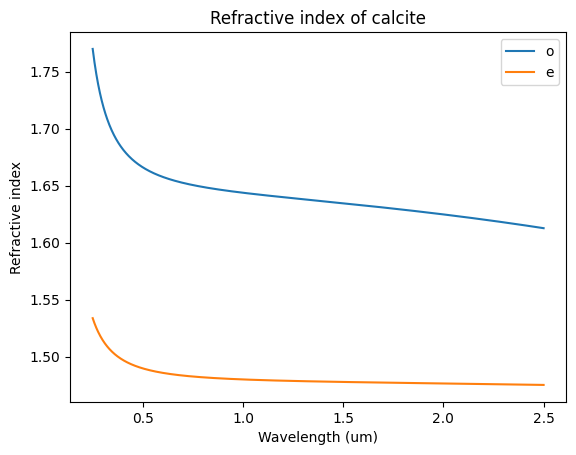

In [3]:
def calcite_sellmeier_n(wavelength, axis="o"):
    """
    Sellmeier equation for calcite crystal
    https://refractiveindex.info
    Ghosh 1999
    """
    if axis == "o":
        A = 1.73358749
        B = 0.96464345
        C = 1.94325203e-2
        D = 1.82831454
        E = 120
    elif axis == "e":
        A = 1.35859695
        B = 0.82427830
        C = 1.06689543e-2
        D = 0.14429128
        E = 120

    n2 = A + B * wavelength**2 / (wavelength**2 - C) + D * wavelength**2 / (wavelength**2 - E)
    return np.sqrt(n2)


# plot the refractive index of calcite
wavelength = np.linspace(0.25, 2.5, 1000)
n_o = calcite_sellmeier_n(wavelength, "o")
n_e = calcite_sellmeier_n(wavelength, "e")
plt.plot(wavelength, n_o)
plt.plot(wavelength, n_e)
plt.legend(["o", "e"])
plt.xlabel("Wavelength (um)")
plt.ylabel("Refractive index")
plt.title("Refractive index of calcite")
plt.show()

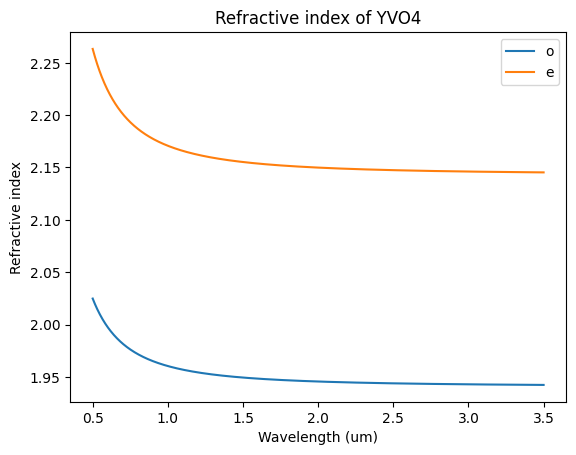

In [4]:
def yvo_sellmeier_n(wavelength, axis='o'):
    """
    Sellmeier equation for YVO4 crystal
    https://refractiveindex.info
    Birnbaum et al., 1976
    """
    if axis == 'o':
        A = 1
        B = 2.7665
        C = 0.026884
    elif axis == 'e':
        A = 1
        B = 3.5930
        C = 0.032103
    n2 = A + B * wavelength**2 / (wavelength**2 - C)
    return np.sqrt(n2)

# plot the refractive index of YVO4
wavelength = np.linspace(0.5, 3.5, 1000)
n_o = yvo_sellmeier_n(wavelength, 'o')
n_e = yvo_sellmeier_n(wavelength, 'e')
plt.plot(wavelength, n_o)
plt.plot(wavelength, n_e)
plt.legend(['o', 'e'])
plt.xlabel('Wavelength (um)')
plt.ylabel('Refractive index')
plt.title('Refractive index of YVO4')
plt.show()

In [5]:
def get_phase(n, thickness, wavelength):
    return 2 * np.pi * n * thickness / wavelength

def calcite_sellmeier_n_eff(wavelength, theta=np.pi/4):
    """
    Effective refractive index of calcite
    """
    no = calcite_sellmeier_n(wavelength, 'o')
    ne = calcite_sellmeier_n(wavelength, 'e')
    n = np.sqrt(no**2 * np.sin(theta)**2 + ne**2 * np.cos(theta)**2)
    return n

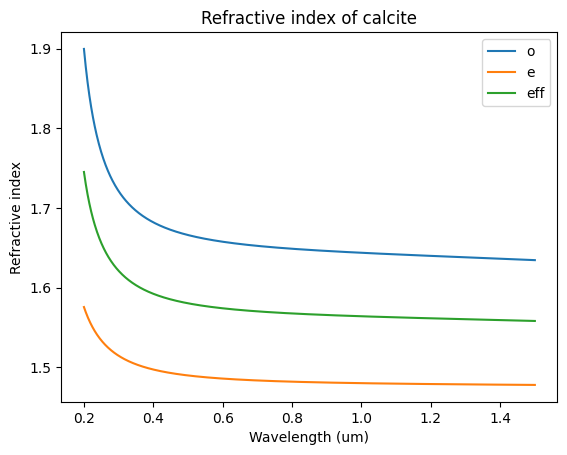

In [6]:
# plot the refractive index of calcite 
wavelength = np.linspace(0.2, 1.5, 1000)
n_o = calcite_sellmeier_n(wavelength, 'o')
n_e = calcite_sellmeier_n(wavelength, 'e')
n_eff = calcite_sellmeier_n_eff(wavelength)
plt.plot(wavelength, n_o)
plt.plot(wavelength, n_e)
plt.plot(wavelength, n_eff)
plt.legend(['o', 'e', 'eff'])
plt.xlabel('Wavelength (um)')
plt.ylabel('Refractive index')
plt.title('Refractive index of calcite')
plt.show()

# Adding Compensation

In [7]:
# optimise to minimise the range over the yvo lengths
from scipy.optimize import minimize

def objective(x):
    l_yvo_pre, l_yvo_post = x
    l_calcite_pre = 12.5e3 # um
    l_calcite_post = 13.3e3 # um

    # Define polarization states
    a = 'o'
    aprime = 'e'
    b = 'e'
    bprime = 'o'

    # Generate data for 3D plot
    pump_wavelengths = np.linspace(0.4052, 0.4056, 10)
    i_wavelengths = np.linspace(0.725, 0.825, 1000)
    X, Y = np.meshgrid(i_wavelengths, pump_wavelengths)
    Z = np.zeros_like(X)

    for i, pump_wavelength in enumerate(pump_wavelengths):
        s_wavelengths = 1 / (1 / pump_wavelength - 1 / i_wavelengths)
        
        n_a_yvo_p = yvo_sellmeier_n(pump_wavelength, a)
        n_o_calcite_p = calcite_sellmeier_n(pump_wavelength, "o")
        n_eff_calcite_i = calcite_sellmeier_n_eff(i_wavelengths)
        n_eff_calcite_s = calcite_sellmeier_n_eff(s_wavelengths)
        n_b_yvo_i = yvo_sellmeier_n(i_wavelengths, b)
        n_b_yvo_s = yvo_sellmeier_n(s_wavelengths, b)
        n_aprime_yvo_p = yvo_sellmeier_n(pump_wavelength, aprime)
        n_eff_calcite_p = calcite_sellmeier_n_eff(pump_wavelength)
        n_o_calcite_i = calcite_sellmeier_n(i_wavelengths, "o")
        n_o_calcite_s = calcite_sellmeier_n(s_wavelengths, "o")
        n_bprime_yvo_i = yvo_sellmeier_n(i_wavelengths, bprime)
        n_bprime_yvo_s = yvo_sellmeier_n(s_wavelengths, bprime)

        phase_h = 2 * np.pi * (
            l_yvo_pre  * n_a_yvo_p   / pump_wavelength + 
            l_calcite_pre  * n_o_calcite_p   / pump_wavelength +
            l_calcite_post * n_eff_calcite_i / i_wavelengths +
            l_calcite_post * n_eff_calcite_s / s_wavelengths +
            l_yvo_post * n_b_yvo_i   / i_wavelengths +
            l_yvo_post * n_b_yvo_s   / s_wavelengths
        )

        phase_v = 2 * np.pi * (
            l_yvo_pre  * n_aprime_yvo_p / pump_wavelength + 
            l_calcite_pre  * n_eff_calcite_p    / pump_wavelength +
            l_calcite_post * n_o_calcite_i      / i_wavelengths +
            l_calcite_post * n_o_calcite_s      / s_wavelengths +
            l_yvo_post * n_bprime_yvo_i / i_wavelengths +
            l_yvo_post * n_bprime_yvo_s / s_wavelengths
        )
        
        Z[i, :] = phase_v - phase_h

    z_range = Z.max() - Z.min()

    return z_range

# pass the objective function to the minimiser
result = minimize(objective, [0.745e3, 0.795e3], method='Nelder-Mead')

# get the optimal lengths
l_yvo_pre, l_yvo_post = result.x

# print in mm
print(f"Optimal YVO4 lengths. Pre = {l_yvo_pre / 1e3:.3f} mm, Post = {l_yvo_post / 1e3:.3f} mm")

Optimal YVO4 lengths. Pre = 1.529 mm, Post = 1.682 mm


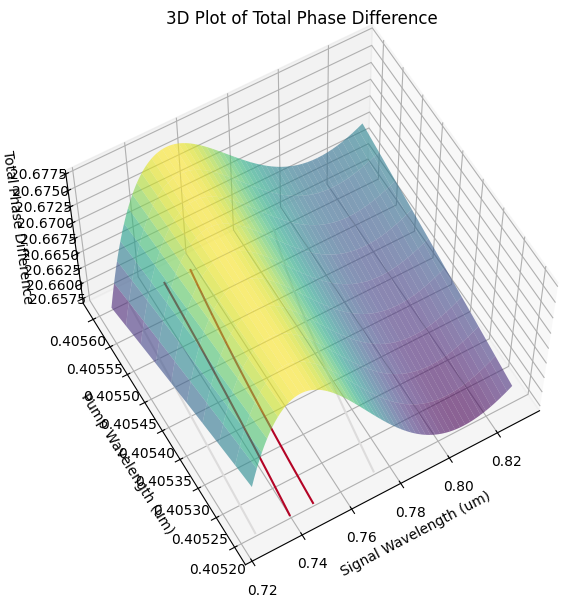

In [8]:
# Use the optimal lengths to generate the 3D plot

l_calcite_pre = 12.5e3 # um
l_calcite_post = 13.3e3 # um

# Define polarization states
a = 'o'
aprime = 'e'
b = 'e'
bprime = 'o'

# Generate data for 3D plot
pump_wavelengths = np.linspace(0.4052, 0.4056, 10)
i_wavelengths = np.linspace(0.725, 0.83, 1000)
X, Y = np.meshgrid(i_wavelengths, pump_wavelengths)
Z = np.zeros_like(X)

for i, pump_wavelength in enumerate(pump_wavelengths):
    s_wavelengths = 1 / (1 / pump_wavelength - 1 / i_wavelengths)
    
    n_a_yvo_p = yvo_sellmeier_n(pump_wavelength, a)
    n_o_calcite_p = calcite_sellmeier_n(pump_wavelength, "o")
    n_eff_calcite_i = calcite_sellmeier_n_eff(i_wavelengths)
    n_eff_calcite_s = calcite_sellmeier_n_eff(s_wavelengths)
    n_b_yvo_i = yvo_sellmeier_n(i_wavelengths, b)
    n_b_yvo_s = yvo_sellmeier_n(s_wavelengths, b)
    n_aprime_yvo_p = yvo_sellmeier_n(pump_wavelength, aprime)
    n_eff_calcite_p = calcite_sellmeier_n_eff(pump_wavelength)
    n_o_calcite_i = calcite_sellmeier_n(i_wavelengths, "o")
    n_o_calcite_s = calcite_sellmeier_n(s_wavelengths, "o")
    n_bprime_yvo_i = yvo_sellmeier_n(i_wavelengths, bprime)
    n_bprime_yvo_s = yvo_sellmeier_n(s_wavelengths, bprime)

    phase_h = 2 * np.pi * (
        l_yvo_pre  * n_a_yvo_p   / pump_wavelength + 
        l_calcite_pre  * n_o_calcite_p   / pump_wavelength +
        l_calcite_post * n_eff_calcite_i / i_wavelengths +
        l_calcite_post * n_eff_calcite_s / s_wavelengths +
        l_yvo_post * n_b_yvo_i   / i_wavelengths +
        l_yvo_post * n_b_yvo_s   / s_wavelengths
    )

    phase_v = 2 * np.pi * (
        l_yvo_pre  * n_aprime_yvo_p / pump_wavelength + 
        l_calcite_pre  * n_eff_calcite_p    / pump_wavelength +
        l_calcite_post * n_o_calcite_i      / i_wavelengths +
        l_calcite_post * n_o_calcite_s      / s_wavelengths +
        l_yvo_post * n_bprime_yvo_i / i_wavelengths +
        l_yvo_post * n_bprime_yvo_s / s_wavelengths
    )
    
    Z[i, :] = phase_v - phase_h

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
ax.set_xlabel("Signal Wavelength (um)")
ax.set_ylabel("Pump Wavelength (um)")
ax.set_zlabel("Total Phase Difference")
ax.set_title("3D Plot of Total Phase Difference")
ax.contour(X, Y, Z, levels=np.arange(Z.min(), Z.max(), 0.01), cmap='coolwarm', offset=Z.min())

z_range = Z.max() - Z.min()

# set the viewing angle
ax.view_init(60, 240)

plt.show()


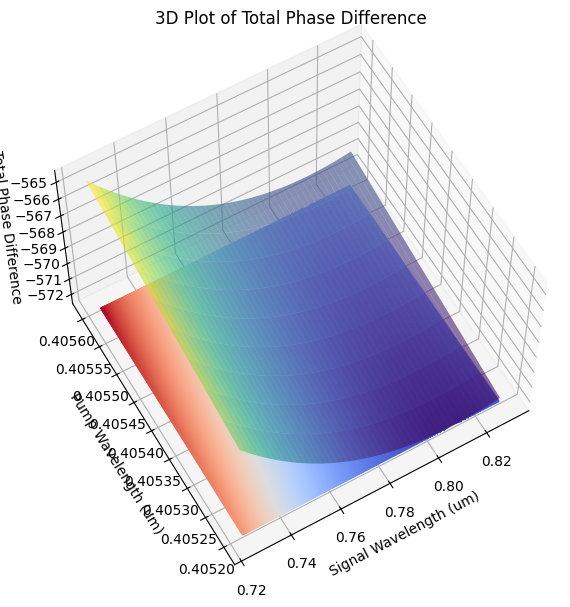

In [9]:
# Use the optimal lengths to generate the 3D plot
l_yvo_pre, l_yvo_post = (0.85e3, 1.03e3) # from original calculation

l_calcite_pre = 12.5e3 # um
l_calcite_post = 13.3e3 # um

# Define polarization states
a = 'o'
aprime = 'e'
b = 'e'
bprime = 'o'

# Generate data for 3D plot
pump_wavelengths = np.linspace(0.4052, 0.4056, 10)
i_wavelengths = np.linspace(0.725, 0.83, 1000)
X, Y = np.meshgrid(i_wavelengths, pump_wavelengths)
Z = np.zeros_like(X)

for i, pump_wavelength in enumerate(pump_wavelengths):
    s_wavelengths = 1 / (1 / pump_wavelength - 1 / i_wavelengths)
    
    n_a_yvo_p = yvo_sellmeier_n(pump_wavelength, a)
    n_o_calcite_p = calcite_sellmeier_n(pump_wavelength, "o")
    n_eff_calcite_i = calcite_sellmeier_n_eff(i_wavelengths)
    n_eff_calcite_s = calcite_sellmeier_n_eff(s_wavelengths)
    n_b_yvo_i = yvo_sellmeier_n(i_wavelengths, b)
    n_b_yvo_s = yvo_sellmeier_n(s_wavelengths, b)
    n_aprime_yvo_p = yvo_sellmeier_n(pump_wavelength, aprime)
    n_eff_calcite_p = calcite_sellmeier_n_eff(pump_wavelength)
    n_o_calcite_i = calcite_sellmeier_n(i_wavelengths, "o")
    n_o_calcite_s = calcite_sellmeier_n(s_wavelengths, "o")
    n_bprime_yvo_i = yvo_sellmeier_n(i_wavelengths, bprime)
    n_bprime_yvo_s = yvo_sellmeier_n(s_wavelengths, bprime)

    phase_h = 2 * np.pi * (
        l_yvo_pre  * n_a_yvo_p   / pump_wavelength + 
        l_calcite_pre  * n_o_calcite_p   / pump_wavelength +
        l_calcite_post * n_eff_calcite_i / i_wavelengths +
        l_calcite_post * n_eff_calcite_s / s_wavelengths +
        l_yvo_post * n_b_yvo_i   / i_wavelengths +
        l_yvo_post * n_b_yvo_s   / s_wavelengths
    )

    phase_v = 2 * np.pi * (
        l_yvo_pre  * n_aprime_yvo_p / pump_wavelength + 
        l_calcite_pre  * n_eff_calcite_p    / pump_wavelength +
        l_calcite_post * n_o_calcite_i      / i_wavelengths +
        l_calcite_post * n_o_calcite_s      / s_wavelengths +
        l_yvo_post * n_bprime_yvo_i / i_wavelengths +
        l_yvo_post * n_bprime_yvo_s / s_wavelengths
    )
    
    Z[i, :] = phase_v - phase_h

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
ax.set_xlabel("Signal Wavelength (um)")
ax.set_ylabel("Pump Wavelength (um)")
ax.set_zlabel("Total Phase Difference")
ax.set_title("3D Plot of Total Phase Difference")
ax.contour(X, Y, Z, levels=np.arange(Z.min(), Z.max(), 0.01), cmap='coolwarm', offset=Z.min())

z_range = Z.max() - Z.min()

# set the viewing angle
ax.view_init(60, 240)

plt.show()


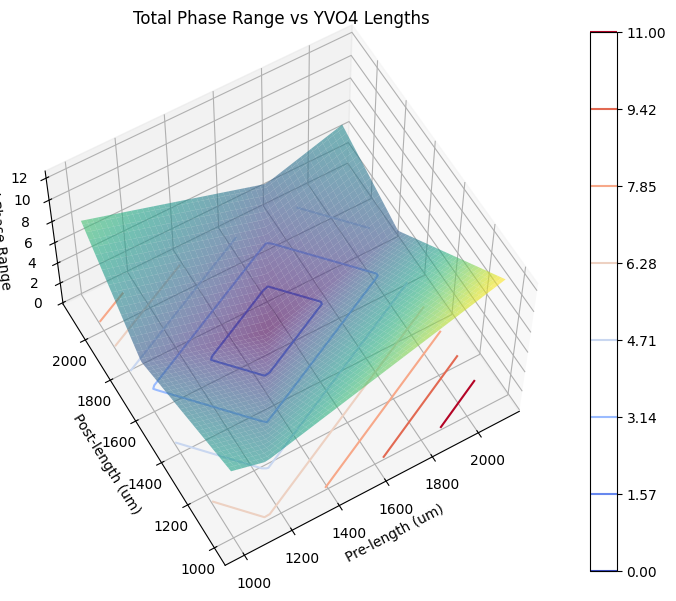

In [14]:
# Optimal YVO4 lengths: 1.529 mm, 1.682 mm

pre_length_range = np.linspace(1e3, 2.1e3, 50)
post_length_range = np.linspace(1e3, 2.1e3, 100)

range_data_X, range_data_Y = np.meshgrid(pre_length_range, post_length_range)
range_data_Z = np.zeros_like(range_data_X)

for i, l_yvo_pre in enumerate(pre_length_range):
    for j, l_yvo_post in enumerate(post_length_range):
        
        l_calcite_pre = 12.5e3 # um
        l_calcite_post = 13.3e3 # um

        # Define polarization states
        a = 'o'
        aprime = 'e'
        b = 'e'
        bprime = 'o'

        # Generate data for 3D plot
        pump_wavelengths = np.linspace(0.4052, 0.4056, 10)
        i_wavelengths = np.linspace(0.725, 0.83, 1000)
        X, Y = np.meshgrid(i_wavelengths, pump_wavelengths)
        Z = np.zeros_like(X)

        for k, pump_wavelength in enumerate(pump_wavelengths):
            s_wavelengths = 1 / (1 / pump_wavelength - 1 / i_wavelengths)
            
            n_a_yvo_p = yvo_sellmeier_n(pump_wavelength, a)
            n_o_calcite_p = calcite_sellmeier_n(pump_wavelength, "o")
            n_eff_calcite_i = calcite_sellmeier_n_eff(i_wavelengths)
            n_eff_calcite_s = calcite_sellmeier_n_eff(s_wavelengths)
            n_b_yvo_i = yvo_sellmeier_n(i_wavelengths, b)
            n_b_yvo_s = yvo_sellmeier_n(s_wavelengths, b)
            n_aprime_yvo_p = yvo_sellmeier_n(pump_wavelength, aprime)
            n_eff_calcite_p = calcite_sellmeier_n_eff(pump_wavelength)
            n_o_calcite_i = calcite_sellmeier_n(i_wavelengths, "o")
            n_o_calcite_s = calcite_sellmeier_n(s_wavelengths, "o")
            n_bprime_yvo_i = yvo_sellmeier_n(i_wavelengths, bprime)
            n_bprime_yvo_s = yvo_sellmeier_n(s_wavelengths, bprime)

            phase_h = 2 * np.pi * (
                l_yvo_pre  * n_a_yvo_p   / pump_wavelength + 
                l_calcite_pre  * n_o_calcite_p   / pump_wavelength +
                l_calcite_post * n_eff_calcite_i / i_wavelengths +
                l_calcite_post * n_eff_calcite_s / s_wavelengths +
                l_yvo_post * n_b_yvo_i   / i_wavelengths +
                l_yvo_post * n_b_yvo_s   / s_wavelengths
            )

            phase_v = 2 * np.pi * (
                l_yvo_pre  * n_aprime_yvo_p / pump_wavelength + 
                l_calcite_pre  * n_eff_calcite_p    / pump_wavelength +
                l_calcite_post * n_o_calcite_i      / i_wavelengths +
                l_calcite_post * n_o_calcite_s      / s_wavelengths +
                l_yvo_post * n_bprime_yvo_i / i_wavelengths +
                l_yvo_post * n_bprime_yvo_s / s_wavelengths
            )
            
            Z[k, :] = phase_v - phase_h

        z_range = Z.max() - Z.min()

        range_data_Z[j, i] = z_range

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(range_data_X, range_data_Y, range_data_Z, cmap='viridis', alpha=0.6)
ax.set_xlabel("Pre-length (um)")
ax.set_ylabel("Post-length (um)")
ax.set_zlabel("Total Phase Range")
ax.set_title("Total Phase Range vs YVO4 Lengths")

cset = ax.contour(range_data_X, range_data_Y, range_data_Z, levels=np.arange(0, range_data_Z.max(), np.pi/2), cmap='coolwarm', offset=range_data_Z.min())
fig.colorbar(cset)

ax.view_init(60, 240)

plt.show()

# save the fig
fig.savefig("phase_difference_optimisation.png")


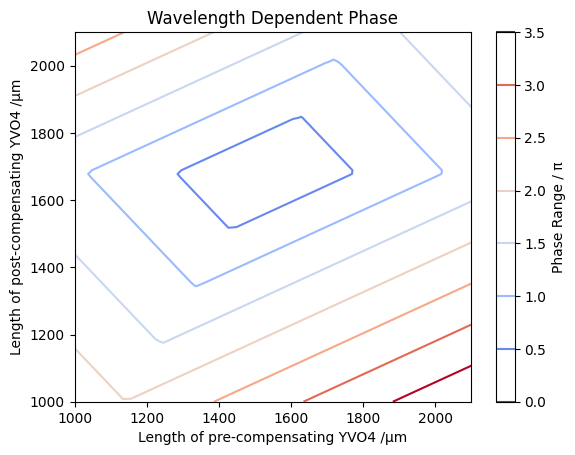

In [ ]:
# plot just the 2d contour
plt.contour(range_data_X, range_data_Y, range_data_Z / np.pi, levels=np.arange(0, range_data_Z.max() / np.pi, 0.5), cmap='coolwarm')
plt.xlabel("Length of pre-compensating YVO4 /μm")
plt.ylabel("Length of post-compensating YVO4 /μm")
plt.title("Wavelength Dependent Phase")
# label the colourbar using the phase range / pi
cbar = plt.colorbar()
cbar.set_label("Phase Range / π")

# save the fig
plt.savefig("phase_difference_optimisation_contour.png")
plt.show()

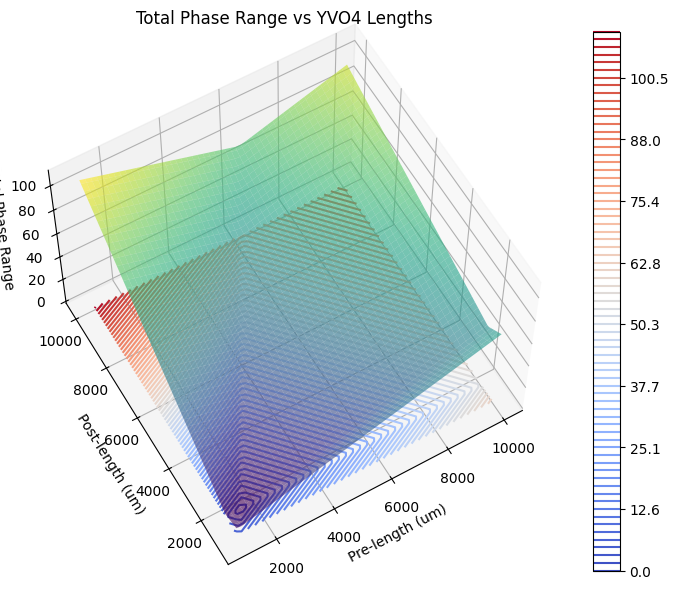

In [27]:
# Optimal YVO4 lengths: 1.529 mm, 1.682 mm

pre_length_range = np.linspace(1e3, 10e3, 50)
post_length_range = np.linspace(1e3, 10e3, 100)

range_data_X, range_data_Y = np.meshgrid(pre_length_range, post_length_range)
range_data_Z = np.zeros_like(range_data_X)

for i, l_yvo_pre in enumerate(pre_length_range):
    for j, l_yvo_post in enumerate(post_length_range):
        
        l_calcite_pre = 12.5e3 # um
        l_calcite_post = 13.3e3 # um

        # Define polarization states
        a = 'o'
        aprime = 'e'
        b = 'e'
        bprime = 'o'

        # Generate data for 3D plot
        pump_wavelengths = np.linspace(0.4052, 0.4056, 10)
        i_wavelengths = np.linspace(0.725, 0.83, 1000)
        X, Y = np.meshgrid(i_wavelengths, pump_wavelengths)
        Z = np.zeros_like(X)

        for k, pump_wavelength in enumerate(pump_wavelengths):
            s_wavelengths = 1 / (1 / pump_wavelength - 1 / i_wavelengths)
            
            n_a_yvo_p = yvo_sellmeier_n(pump_wavelength, a)
            n_o_calcite_p = calcite_sellmeier_n(pump_wavelength, "o")
            n_eff_calcite_i = calcite_sellmeier_n_eff(i_wavelengths)
            n_eff_calcite_s = calcite_sellmeier_n_eff(s_wavelengths)
            n_b_yvo_i = yvo_sellmeier_n(i_wavelengths, b)
            n_b_yvo_s = yvo_sellmeier_n(s_wavelengths, b)
            n_aprime_yvo_p = yvo_sellmeier_n(pump_wavelength, aprime)
            n_eff_calcite_p = calcite_sellmeier_n_eff(pump_wavelength)
            n_o_calcite_i = calcite_sellmeier_n(i_wavelengths, "o")
            n_o_calcite_s = calcite_sellmeier_n(s_wavelengths, "o")
            n_bprime_yvo_i = yvo_sellmeier_n(i_wavelengths, bprime)
            n_bprime_yvo_s = yvo_sellmeier_n(s_wavelengths, bprime)

            phase_h = 2 * np.pi * (
                l_yvo_pre  * n_a_yvo_p   / pump_wavelength + 
                l_calcite_pre  * n_o_calcite_p   / pump_wavelength +
                l_calcite_post * n_eff_calcite_i / i_wavelengths +
                l_calcite_post * n_eff_calcite_s / s_wavelengths +
                l_yvo_post * n_b_yvo_i   / i_wavelengths +
                l_yvo_post * n_b_yvo_s   / s_wavelengths
            )

            phase_v = 2 * np.pi * (
                l_yvo_pre  * n_aprime_yvo_p / pump_wavelength + 
                l_calcite_pre  * n_eff_calcite_p    / pump_wavelength +
                l_calcite_post * n_o_calcite_i      / i_wavelengths +
                l_calcite_post * n_o_calcite_s      / s_wavelengths +
                l_yvo_post * n_bprime_yvo_i / i_wavelengths +
                l_yvo_post * n_bprime_yvo_s / s_wavelengths
            )
            
            Z[k, :] = phase_v - phase_h

        z_range = Z.max() - Z.min()

        range_data_Z[j, i] = z_range

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(range_data_X, range_data_Y, range_data_Z, cmap='viridis', alpha=0.6)
ax.set_xlabel("Pre-length (um)")
ax.set_ylabel("Post-length (um)")
ax.set_zlabel("Total Phase Range")
ax.set_title("Total Phase Range vs YVO4 Lengths")

cset = ax.contour(range_data_X, range_data_Y, range_data_Z, levels=np.arange(0, range_data_Z.max(), np.pi/2), cmap='coolwarm', offset=range_data_Z.min())
fig.colorbar(cset)

ax.view_init(60, 240)

plt.show()

# save the fig
fig.savefig("phase_difference_optimisation.png")


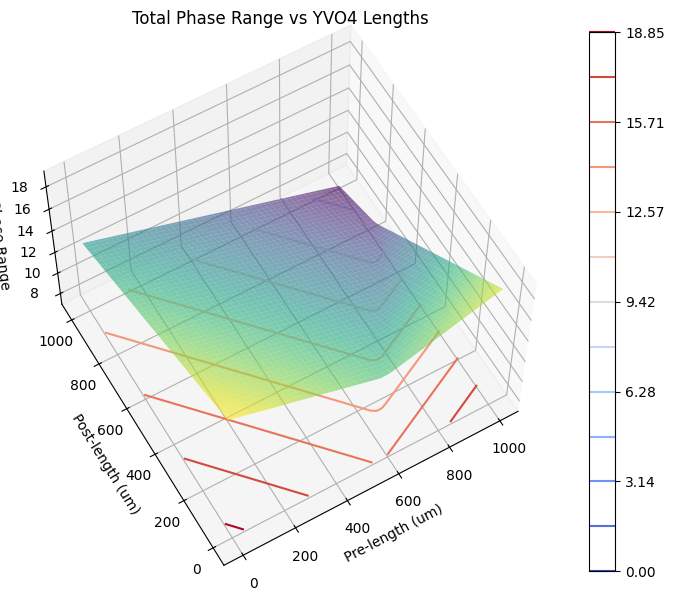

In [ ]:
# Optimal YVO4 lengths: 1.529 mm, 1.682 mm

pre_length_range = np.linspace(0, 1e3, 50)
post_length_range = np.linspace(0, 1e3, 100)

range_data_X, range_data_Y = np.meshgrid(pre_length_range, post_length_range)
range_data_Z = np.zeros_like(range_data_X)

for i, l_yvo_pre in enumerate(pre_length_range):
    for j, l_yvo_post in enumerate(post_length_range):
        
        l_calcite_pre = 12.5e3 # um
        l_calcite_post = 13.3e3 # um

        # Define polarization states
        a = 'o'
        aprime = 'e'
        b = 'e'
        bprime = 'o'

        # Generate data for 3D plot
        pump_wavelengths = np.linspace(0.4052, 0.4056, 10)
        i_wavelengths = np.linspace(0.725, 0.83, 1000)
        X, Y = np.meshgrid(i_wavelengths, pump_wavelengths)
        Z = np.zeros_like(X)

        for k, pump_wavelength in enumerate(pump_wavelengths):
            s_wavelengths = 1 / (1 / pump_wavelength - 1 / i_wavelengths)
            
            n_a_yvo_p = yvo_sellmeier_n(pump_wavelength, a)
            n_o_calcite_p = calcite_sellmeier_n(pump_wavelength, "o")
            n_eff_calcite_i = calcite_sellmeier_n_eff(i_wavelengths)
            n_eff_calcite_s = calcite_sellmeier_n_eff(s_wavelengths)
            n_b_yvo_i = yvo_sellmeier_n(i_wavelengths, b)
            n_b_yvo_s = yvo_sellmeier_n(s_wavelengths, b)
            n_aprime_yvo_p = yvo_sellmeier_n(pump_wavelength, aprime)
            n_eff_calcite_p = calcite_sellmeier_n_eff(pump_wavelength)
            n_o_calcite_i = calcite_sellmeier_n(i_wavelengths, "o")
            n_o_calcite_s = calcite_sellmeier_n(s_wavelengths, "o")
            n_bprime_yvo_i = yvo_sellmeier_n(i_wavelengths, bprime)
            n_bprime_yvo_s = yvo_sellmeier_n(s_wavelengths, bprime)

            phase_h = 2 * np.pi * (
                l_yvo_pre  * n_a_yvo_p   / pump_wavelength + 
                l_calcite_pre  * n_o_calcite_p   / pump_wavelength +
                l_calcite_post * n_eff_calcite_i / i_wavelengths +
                l_calcite_post * n_eff_calcite_s / s_wavelengths +
                l_yvo_post * n_b_yvo_i   / i_wavelengths +
                l_yvo_post * n_b_yvo_s   / s_wavelengths
            )

            phase_v = 2 * np.pi * (
                l_yvo_pre  * n_aprime_yvo_p / pump_wavelength + 
                l_calcite_pre  * n_eff_calcite_p    / pump_wavelength +
                l_calcite_post * n_o_calcite_i      / i_wavelengths +
                l_calcite_post * n_o_calcite_s      / s_wavelengths +
                l_yvo_post * n_bprime_yvo_i / i_wavelengths +
                l_yvo_post * n_bprime_yvo_s / s_wavelengths
            )
            
            Z[k, :] = phase_v - phase_h

        z_range = Z.max() - Z.min()

        range_data_Z[j, i] = z_range

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(range_data_X, range_data_Y, range_data_Z, cmap='viridis', alpha=0.6)
ax.set_xlabel("Pre-length (um)")
ax.set_ylabel("Post-length (um)")
ax.set_zlabel("Total Phase Range")
ax.set_title("Total Phase Range vs YVO4 Lengths")

cset = ax.contour(range_data_X, range_data_Y, range_data_Z, levels=np.arange(0, range_data_Z.max(), np.pi/2), cmap='coolwarm', offset=range_data_Z.min())
fig.colorbar(cset)

ax.view_init(60, 240)

plt.show()

# save the fig
fig.savefig("phase_difference_optimisation.png")


# Conclusions

Should be fine to use around the optimal lengths of YVO4: 1.529 mm, 1.682 mm